In [1]:
from typing import Union, Self
from numbers import Number
from itertools import chain, product

import numpy as np
import sympy as sp
import cvxpy as cp

import scipy
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from scipy.linalg import qr
from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import splu, svds
from sksparse.cholmod import cholesky

from bmn.algebra import MatrixOperator, SingleTraceOperator, MatrixSystem, DoubleTraceOperator
from bmn.linear_algebra import get_null_space_dense, create_sparse_matrix_from_dict, get_row_space_dense, get_null_space_sparse
from bmn.bootstrap import BootstrapSystem
from bmn.solver import (
    minimal_eigval,
    sdp_init, sdp_relax,
    sdp_minimize,
    minimize,
    get_quadratic_constraint_vector_sparse,
    get_quadratic_constraint_vector_dense,
    compute_L2_norm_of_quadratic_constraints,
)
from bmn.brezin import compute_Brezin_energy, compute_Brezin_energy_Han_conventions

from bmn.debug_utils import disable_debug

np.set_printoptions(linewidth=120)  # Adjust the number to the desired width

# plot settings
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
    )
matplotlib.rcParams.update(
    {"axes.grid":True,
    "grid.alpha":0.75,
    "grid.linewidth":0.5}
    )
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

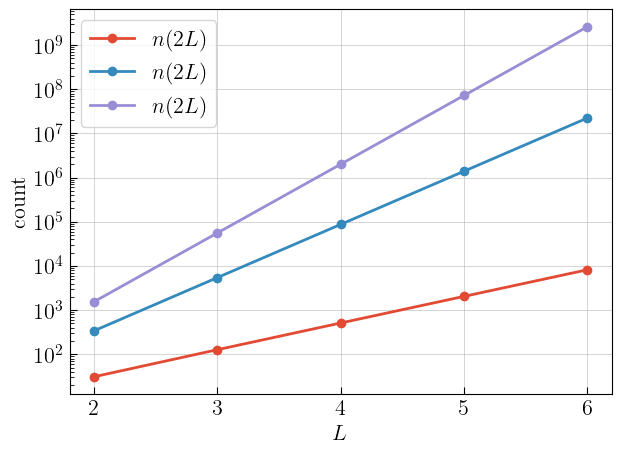

In [2]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]
d = 2

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 4)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-o', label="$n(2L)$", color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"count")
ax.legend()
#    ax.set_title(f"Growth of operators for d={d}")
ax.set_yscale('log')
plt.show()

## BFSS

In [3]:
L = 2

matrix_system = MatrixSystem(
    operator_basis=["X0", "X1", "X2", "Pi0", "Pi1", "Pi2"],
    commutation_rules_concise={
        ("Pi0", "X0"): 1,  # use Pi' = i P to ensure reality
        ("Pi1", "X1"): 1,
        ("Pi2", "X2"): 1,
    },
    hermitian_dict={
        "Pi0": False,
        "X0": True,
        "Pi1": False,
        "X1": True,
        "Pi2": False,
        "X2": True,
        },
)

# lambda = 1 here
hamiltonian = SingleTraceOperator(
    data={
        ("Pi0", "Pi0"): -0.5,
        ("Pi1", "Pi1"): -0.5,
        ("Pi2", "Pi2"): -0.5,
        # quartic term (XY)
        ("X0", "X1", "X0", "X1"): -1 / 4,
        ("X1", "X0", "X1", "X0"): -1 / 4,
        ("X0", "X1", "X1", "X0"): 1 / 4,
        ("X1", "X0", "X0", "X1"): 1 / 4,
        # quartic term (XZ)
        ("X0", "X2", "X0", "X2"): -1 / 4,
        ("X2", "X0", "X2", "X0"): -1 / 4,
        ("X0", "X2", "X2", "X0"): 1 / 4,
        ("X2", "X0", "X0", "X2"): 1 / 4,
        # quartic term (YZ)
        ("X1", "X2", "X1", "X2"): -1 / 4,
        ("X2", "X1", "X2", "X1"): -1 / 4,
        ("X1", "X2", "X2", "X1"): 1 / 4,
        ("X2", "X1", "X1", "X2"): 1 / 4,
    }
)

# <tr G O > = 0
gauge = MatrixOperator(data={
    ("X0", "Pi0"): 1,
    ("Pi0", "X0"): -1,
    ("X1", "Pi1"): 1,
    ("Pi1", "X1"): -1,
    ("X2", "Pi2"): 1,
    ("Pi2", "X2"): -1,
    (): 3,
    })

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    max_degree_L=L,
    odd_degree_vanish=True,
    simplify_quadratic=True,
)

bootstrap.get_null_space_matrix()
quadratic_constraints = bootstrap.build_quadratic_constraints()

Assuming all operators are either Hermitian or anti-Hermitian.
NOTE Remember to incorporate more general basis changes!
Bootstrap system instantiated for 1555 operators
Attribute: simplify_quadratic = True
Generated 297 Hamiltonian constraints
Generated 43 gauge constraints
Generated 1491 reality constraints
Generated 222 odd degree vanish constraints
Generated 1314 linear cyclic constraints
Generated 216 quadratic cyclic constraints
Null space dimension (number of parameters) = 214
Building quadratic constraints: adding 216 new linear constraints and rebuilding null matrix
Null space dimension (number of parameters) = 160
Number of quadratic constraints before row reduction: 1
Number of quadratic constraints after row reduction: 1


In [4]:
param = np.random.normal(size=bootstrap.param_dim_null)

In [5]:
val1, grad1 = get_quadratic_constraint_vector_dense(
    quadratic_constraints=quadratic_constraints,
    param=param,
    compute_grad=True,
    )

val2, grad2 = get_quadratic_constraint_vector_sparse(
    quadratic_constraints=quadratic_constraints,
    param=param,
    compute_grad=True,
    )

In [6]:
np.allclose(val1, val2), np.allclose(grad1, grad2.todense())

(True, True)

## One Matrix Model

In [7]:
g = 2.5
L = 3
init = None

matrix_system = MatrixSystem(
    # operator_basis=['X', 'P'],
    operator_basis=["X", "Pi"],
    commutation_rules_concise={
        # ('P', 'X'): -1j,
        ("Pi", "X"): 1,  # use Pi' = i P to ensure reality
    },
    # hermitian_dict={'P': True, 'X': True},
    hermitian_dict={"Pi": False, "X": True},
)

# scale variables as P = sqrt(N) P', X = sqrt(N) X'
hamiltonian = SingleTraceOperator(
    # data={("P", "P"): 1, ("X", "X"): 1, ("X", "X", "X", "X"): 7}
    data={("Pi", "Pi"): -1, ("X", "X"): 1, ("X", "X", "X", "X"): g}
)

# <tr G O > = 0 might need to be applied only for O with deg <= L-2
# gauge = MatrixOperator(data={('X', 'P'): 1j, ('P', 'X'): -1j, ():1})
gauge = MatrixOperator(data={("X", "Pi"): 1, ("Pi", "X"): -1, (): 1})

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    max_degree_L=L,
    odd_degree_vanish=True,
    simplify_quadratic=True,
)

bootstrap.get_null_space_matrix()
quadratic_constraints = bootstrap.build_quadratic_constraints()

Assuming all operators are either Hermitian or anti-Hermitian.
NOTE Remember to incorporate more general basis changes!
Bootstrap system instantiated for 127 operators
Attribute: simplify_quadratic = True
Generated 64 Hamiltonian constraints
Generated 31 gauge constraints
Generated 105 reality constraints
Generated 42 odd degree vanish constraints
Generated 26 linear cyclic constraints
Generated 88 quadratic cyclic constraints
Null space dimension (number of parameters) = 25
Building quadratic constraints: adding 28 new linear constraints and rebuilding null matrix
Null space dimension (number of parameters) = 14
Number of quadratic constraints before row reduction: 33
Number of quadratic constraints after row reduction: 10


In [8]:
param = np.random.normal(size=bootstrap.param_dim_null)

val1, grad1 = get_quadratic_constraint_vector_dense(
    quadratic_constraints=quadratic_constraints,
    param=param,
    compute_grad=True,
    )

val2, grad2 = get_quadratic_constraint_vector_sparse(
    quadratic_constraints=quadratic_constraints,
    param=param,
    compute_grad=True,
    )

np.allclose(val1, val2), np.allclose(grad1, grad2.todense())

(True, True)

In [9]:
#disable_debug()

param, success = minimize(
    bootstrap=bootstrap,
    op=bootstrap.hamiltonian,
    init=init,
    init_scale=1e2,
    verbose=False,
    maxiters=25,
    relax_rate=0.8,
    reg=5e-4,
    eps=1e-4,
)

energy = bootstrap.get_operator_expectation_value(
    st_operator=hamiltonian,
    param=param
    )
exact_energy = compute_Brezin_energy_Han_conventions(g)
print(f"problem success: {success}, min energy found: {energy:.6f}, exact (L=inf) value = {exact_energy:.6f}")

Number of quadratic constraints before row reduction: 33
Number of quadratic constraints after row reduction: 10
Initializing randomly
DEBUG 08:11:02.687008: Starting from scratch...
initial ||param||_2 = 7.629196881855507, R=27.629196881855506
step = 1/25
DEBUG 08:11:02.695851: step = 1/25
[0.0152876  0.01016631 0.00225109 0.00697805 0.00553156 0.00161041 0.0046351  0.02544486 0.01163993 0.01363342]
Step 0: 	loss = 1.76531, maxcv = 74.82187, radius = 2.763e+01, min_eig = -0.00000
		norm = 7.62920, update = 1.87472e+00
  adjusting mu from mu = 1 to mu = 1
step = 2/25
DEBUG 08:11:02.730354: step = 2/25
Step 1: 	loss = 1.55193, maxcv = 2.84927, radius = 2.763e+01, min_eig = -0.00118
		norm = 6.10387, update = 3.81809e-02
  adjusting mu from mu = 1 to mu = 1
step = 3/25
DEBUG 08:11:02.755034: step = 3/25
Step 2: 	loss = 1.55158, maxcv = 0.01271, radius = 2.763e+01, min_eig = -0.00232
		norm = 6.12852, update = 2.70161e-03
  adjusting mu from mu = 1 to mu = 1
step = 4/25
DEBUG 08:11:02.785

In [ ]:
val, grad = compute_L2_norm_of_quadratic_constraints(
    quadratic_constraints=bootstrap.build_quadratic_constraints(),
    param=param,
    )

In [ ]:
bootstrap_array_sparse=bootstrap.build_bootstrap_table()
dim = int(np.sqrt(bootstrap_array_sparse.shape[0]))
bootstrap_matrix = np.reshape(
    bootstrap_array_sparse.dot(param), (dim, dim)
)
scipy.linalg.eigvalsh(bootstrap_matrix)

In [ ]:
for op in bootstrap.operator_list:
    eV = bootstrap.get_operator_expectation_value(
        st_operator=SingleTraceOperator({op: 1}),
        param=param
        )
    if np.abs(eV) > 1e-10:
        print(f"<tr({op})> = {eV}")

Let's try implementing the optimization from scratch

In [ ]:
num_variables = bootstrap.param_dim_null
dim = bootstrap.bootstrap_matrix_dim
verbose = False
maxiters = 200
eps = 1e-4
penalty_parameter = 1

vec = bootstrap.single_trace_to_coefficient_vector(st_operator=hamiltonian, return_null_basis=True)

param = cp.Variable(num_variables)

bootstrap_array_sparse=bootstrap.build_bootstrap_table()
op_cons = [SingleTraceOperator(data={(): 1})]
quadratic_constraints = bootstrap.build_quadratic_constraints()
num_quad_constraints = quadratic_constraints['quadratic'].shape[0]

A_op = sparse.csr_matrix((0, bootstrap.param_dim_null))
b_op = np.zeros(0)
for op in op_cons:
    A_op = sparse.vstack(
        [
            A_op,
            sparse.csr_matrix(
                bootstrap.single_trace_to_coefficient_vector(
                    op, return_null_basis=True
                )
            ),
        ]
    )
    b_op = np.append(b_op, 1)

constraints = [cp.reshape(bootstrap_array_sparse @ param, (bootstrap.bootstrap_matrix_dim, bootstrap.bootstrap_matrix_dim)) >> 0]
constraints += [A_op @ param == b_op]

In [ ]:
penalty_factor = 10  # Initial penalty factor

Q = [quadratic_constraints['quadratic'][k].reshape((num_variables, num_variables)).todense() for k in range(num_quad_constraints)]
c = [quadratic_constraints['linear'][k] for k in range(num_quad_constraints)]

slack = cp.Variable(len(Q))
# Quadratic constraints with slack variables
for i in range(len(Q)):
    constraints += [param.T @ Q[i] @ param + c[i] @ param <= slack[i]]
    constraints += [param.T @ Q[i] @ param + c[i] @ param >= -slack[i]]

objective = cp.Minimize(vec @ param + penalty_factor * cp.sum(slack))
problem = cp.Problem(objective, constraints)
problem.solve(verbose=verbose, max_iters=maxiters, eps=eps, solver=cp.SCS)

In [ ]:
energy = bootstrap.get_operator_expectation_value(
    st_operator=hamiltonian,
    param=param.value
    )
exact_energy = compute_Brezin_energy_Han_conventions(g)
print(f"problem success: {success}, min energy found: {energy:.6f}, exact (L=inf) value = {exact_energy:.6f}")


In [ ]:
new_constraints = []
new_vars = {}
for i in range(num_variables):
    for j in range(num_variables):
        if i <= j:
            new_var = cp.Variable()
            new_vars[(i, j)] = new_var
            new_vars[(j, i)] = new_var
            new_constraints.append(new_var == param[i] * param[j])

for k in []: #range(num_quad_constraints):
    quad = quadratic_constraints['quadratic'][k].reshape((num_variables, num_variables)).todense()
    quad = (quad + quad.T)/2
    lin = quadratic_constraints['linear'][k]
    new_constraints.append(
        sum(quad[i, j] * new_vars[(i, j)] for i in range(num_variables) for j in range(num_variables)) + lin @ param == 0
    )

In [ ]:
constraints.extend(new_constraints)
objective = cp.Minimize(vec @ param)
problem = cp.Problem(objective, constraints)
problem.solve(verbose=verbose, max_iters=maxiters, eps=eps, solver=cp.SCS)

energy = bootstrap.get_operator_expectation_value(
    st_operator=hamiltonian,
    param=param.value
    )
exact_energy = compute_Brezin_energy_Han_conventions(g)
print(f"problem success: {success}, min energy found: {energy:.6f}, exact (L=inf) value = {exact_energy:.6f}")


In [ ]:
x = new_vars[(i, j)] == param[i] * param[j]
x.is_dcp()

In [ ]:
param * param

In [ ]:
x

In [ ]:
for i in range(num_quad_constraints):
    quad = quadratic_constraints['quadratic'][i].reshape((num_variables, num_variables))
    lin = quadratic_constraints['linear'][i]
    assert np.allclose(quad.T.todense(), quad.todense())
    constraints += [cp.quad_form(x=param, P=quad) + lin @ param >= 0]

    eigs = scipy.linalg.eigvalsh(quad.todense())
    print(f"i = {i}, min_eig = {eigs[0]}, max_eig = {eigs[-1]}")

In [ ]:
minimal_eigval(
    bootstrap_array_sparse=bootstrap.build_bootstrap_table(),
    parameter_vector_null=param
    )

In [ ]:
g = 2
L = 3

print(f"One matrix problem, L={L}, g={g}.")

matrix_system = MatrixSystem(
    # operator_basis=['X', 'P'],
    operator_basis=["A", "B", "C"],
    commutation_rules_concise={
        # ('P', 'X'): -1j,
        ("A", "B"): 1,  # use Pi' = i P to ensure reality
        ("A", "C"): 2,  # use Pi' = i P to ensure reality
        ("B", "C"): 3,  # use Pi' = i P to ensure reality
    },
    hermitian_dict={'A': True, 'B': True, 'C':True},
)

hamiltonian = SingleTraceOperator(data={():1})
gauge = MatrixOperator(data={(): 1})

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    half_max_degree=L,
    odd_degree_vanish=True,
)


In [ ]:
bootstrap.operator_list

In [ ]:
bootstrap.operator_dict


In [ ]:
len(bootstrap.operator_list), len(bootstrap.operator_dict)

In [ ]:
operators_by_degree = {}
degree_func = lambda x: len(x)
for op in bootstrap.operator_list:
    degree = degree_func(op)
    if degree not in operators_by_degree:
        operators_by_degree[degree] = [op]
    else:
        operators_by_degree[degree].append(op)

new_list = []
for deg, op_list in operators_by_degree.items():
    if deg % 2 == 0:
        new_list.extend(op_list)

for deg, op_list in operators_by_degree.items():
    if deg % 2 != 0:
        new_list.extend(op_list)

new_list

In [ ]:
operators_by_degree

In [ ]:
op1 = SingleTraceOperator(data={("A", "C", "B", "A"): 1, ("B", "C", "C"): 0})
op2 = SingleTraceOperator(data={("C", "A", "B"): 1})

print(f"[O1, O2]_Han = {bootstrap.matrix_system.single_trace_commutator(op1, op2, verbose=False)}")
print("")
print(f"[O2, O1]_Han = {bootstrap.matrix_system.single_trace_commutator(op2, op1, verbose=False)}")

print("")
print(f"[O1, O2]_Gavin = {bootstrap.matrix_system.single_trace_commutator2(op1, op2, verbose=False)}")
print("")
print(f"[O2, O1]_Gavin = {bootstrap.matrix_system.single_trace_commutator2(op2, op1, verbose=False)}")

In [ ]:
bootstrap.matrix_system.single_trace_commutator(op2, op1) == - 1 * bootstrap.matrix_system.single_trace_commutator2(op1, op2)

In [ ]:
bootstrap.matrix_system.single_trace_commutator(op1, op2, verbose=True)

In [ ]:
bootstrap.matrix_system.single_trace_commutator(op2, op1) + 1 * bootstrap.matrix_system.single_trace_commutator2(op1, op2)

In [ ]:
bootstrap.matrix_system.single_trace_commutator(op2, op1)

In [ ]:
bootstrap.matrix_system.single_trace_commutator2(op1, op2)

In [ ]:
bootstrap.matrix_system.single_trace_commutator2(op1, op2)

In [ ]:
normalization_constraint = {
    'lhs': SingleTraceOperator(data={(): 1}),
    'rhs': DoubleTraceOperator(data={((), ()): 1})
    }
lhs = normalization_constraint["lhs"]
rhs = normalization_constraint["rhs"]
linear_constraint_vector = bootstrap.single_trace_to_coefficient_vector(lhs)
quadratic_matrix = bootstrap.double_trace_to_coefficient_matrix(rhs)

In [ ]:
linear_constraint_vector

In [ ]:
quadratic_matrix

In [ ]:
for op in bootstrap.operator_list[1:4]:
    comm1 = bootstrap.matrix_system.single_trace_commutator(bootstrap.hamiltonian, SingleTraceOperator(data={op:1}))
    #comm2 = bootstrap.matrix_system.single_trace_commutator2(bootstrap.hamiltonian, SingleTraceOperator(data={op:1}))
    comm2b = bootstrap.matrix_system.single_trace_commutator2(SingleTraceOperator(data={op:1}), hamiltonian)
    if comm1 != -1 * comm2b:
        print(f"op = {op},\n commutator(H,op) = {comm1},\n commutator2(op,H) = {comm2b}")

In [ ]:
g, h = 1, 3
matrix_system = MatrixSystem(
    operator_basis=["A", "B", "C", "D"],
    commutation_rules_concise={
        #("P1", "X1"): -1j,
        #("P2", "X2"): -1j,
    },
    hermitian_dict={"A": True, "B": True, "C": True, "D": True},
)
hamiltonian = SingleTraceOperator(
    data={
        ("A", "B"): 1
        #("P1", "P1"): 1,
        #("X1", "X1"): 1,
        #("P2", "P2"): 1,
        #("X2", "X2"): 1,
        #("X1", "X2", "X1", "X2"): -2 * g,
        #("X1", "X1", "X2", "X2"): 2 * g + 2 * h,
        #("X1", "X1", "X1", "X1"): h,
        #("X2", "X2", "X2", "X2"): h,
        # ("X1", "X1", "X2", "X2"): 2*h,
    }
)

#S2 = SingleTraceOperator(data={("X1", "P2"): 1, ("X2", "P1"): 0})
S2 = SingleTraceOperator(data={("C", "D"): 1})

In [ ]:
#print(f'starting term = {S2.operators[0] + ("|",) + hamiltonian.operators[0]}')
print(f'starting term = {hamiltonian.operators[0] + ("|",) + S2.operators[0]}')
new = matrix_system.single_trace_commutator(hamiltonian, S2)

In [ ]:
for i in None:
    print(i)

In [ ]:
#print(f'starting term = {S2.operators[0] + ("|",) + hamiltonian.operators[0]}')
print(f'starting term = {hamiltonian.operators[0] + ("|",) + S2.operators[0]}')
new = matrix_system.single_trace_commutator2(hamiltonian, S2)

In [ ]:
print(f'starting term = {S2.operators[0] + ("|",) + hamiltonian.operators[0]}')
original = matrix_system.single_trace_commutator(hamiltonian, S2)
print('')
print(f'starting term = {S2.operators[0] + ("|",) + hamiltonian.operators[0]}')
new = matrix_system.single_trace_commutator2(S2, hamiltonian)